In [49]:
from langchain_openai import AzureOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain_openai import AzureOpenAIEmbeddings

from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd

import os

In [50]:
API_KEY = os.getenv("AZURE_OPENAI_API_KEY") 
RESOURCE_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT") 

azure_client = AzureOpenAI(
                api_key=API_KEY
                ,api_version='2023-05-15'
                ,azure_endpoint=RESOURCE_ENDPOINT
                ,azure_deployment='gpt-35-turbo-instruct'
                ,temperature=0
                ,max_tokens=1000
                #,model_kwargs={"response_format": {"type": "json_object"}}
)

In [51]:
loader = PyPDFLoader("./lotr.pdf")

pages = loader.load_and_split()

In [52]:
prologue_pages = pages[24:39]
# Python for loop in one line
prologue_text = ''
for page in prologue_pages : prologue_text += page.page_content

In [53]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 800,
    chunk_overlap  = 80
)

docs = text_splitter.create_documents([prologue_text])
print(len(docs))

53


In [54]:
embeddings = AzureOpenAIEmbeddings(
    azure_deployment="ada-embedding",
    openai_api_version="2023-06-01-preview",
)

In [55]:
vectors = embeddings.embed_documents([doc.page_content for doc in docs])

In [56]:
from sklearn.manifold import TSNE

import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce from 1536 dimension to 2 dimensions
tsne = TSNE(n_components=2, perplexity=5, random_state=12)

vectors = np.array(vectors)
reduced_data_tsne = tsne.fit_transform(vectors)

In [57]:
def calculateSilhouetteAvg(num_clusters, data):
    simplefilter(action='ignore', category=FutureWarning)
    simplefilter(action='ignore', category=Warning)
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(data)

    labels = kmeans.labels_

    matrix = np.vstack(vectors)
    matrix.shape

    sample_silhouette_values = metrics.silhouette_samples(matrix, labels)

    means_lst = []
    for label in range(num_clusters):
        means_lst.append(sample_silhouette_values[labels == label].mean())
    
    return (num_clusters, sum(means_lst) / len(means_lst) , labels)

In [70]:
def getBestClusteringResult(data):
    best_result = None
    for i in range(4,20):
        result = calculateSilhouetteAvg(i, data)
        print(result)
        if best_result is None or result[1] > best_result[1]:
            best_result = result
    
    return best_result

In [71]:
final = getBestClusteringResult(reduced_data_tsne)

(4, 0.08986270858628234, array([2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0]))
(5, 0.1255374006389683, array([3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4]))
(6, 0.10626848113387306, array([4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5,
       5, 5, 5, 2, 2, 2, 2, 2, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3]))
(7, 0.1036249287092696, array([5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 1, 6, 6, 6, 6, 6, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 4, 4, 4, 4, 4, 4, 4, 4]))
(8, 0.09920520187829586, array([2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5,
       5, 5, 5, 2, 7, 7, 7, 7, 7, 0, 6, 6, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6,
   

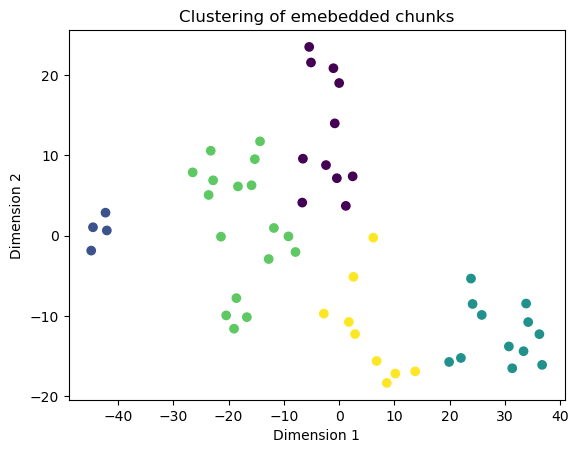

In [72]:

# Plot the reduced data
import matplotlib.pyplot as plt
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=final[2])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Clustering of emebedded chunks')
plt.show()

In [73]:
final_labels = final[2]

In [74]:
print(len(docs), len(final_labels))

53 53


In [75]:
data =  [(doc.page_content, label) for doc, label in zip(docs, final_labels)]

df = pd.DataFrame(data, columns=['doc', 'label'])
df

,doc,label
0,"3 PR OL OGU E \namong them, but there remained...",3
1,they later undertook the hard and perilous cro...,3
2,larger; and they preferred ﬂat lands and river...,3
3,and were less shy of Men. They came west after...,3
4,leaders or chieftains among clans of Harfoots ...,3
5,their earlier settlements had long disappeared...,3
6,"to Gondor, and about all the coasts of the Sea...",3
7,"Kingdom, and they took all the land beyond to ...",0
8,"line, which came to an end with Arvedui three ...",0
9,thousand years they were little troubled by wa...,0


In [76]:
print(df["label"].unique())
distinct_labels = df["label"].unique()

[3 0 1 2 4]


In [77]:
prompt = PromptTemplate(
    template="""
### Instructions:
Summarize the text in narrative form. 
Your summary will be added to other summaries so do not give an introduction to the summary, assume the reader has context for what you are telling them. 
### Text:\n {text}"""
    ,input_variables=["text"]
)

In [78]:
chain = (
    {"text": RunnablePassthrough()} 
        | prompt
        | azure_client
        | StrOutputParser()
    )

In [79]:
def sumarizeText(chain, text):
    return chain.invoke(text)

In [80]:
summary = []
for i in distinct_labels:
    rows = df.loc[df["label"] == i]
    text = rows["doc"].tolist()
    summary.append(sumarizeText(chain, text))

print(' '.join(summary))



Hobbits were a peaceful and clannish people who lived in the Shire. They had a love for good food and drink, and were skilled in the art of pipe-weed. Their history and legends only went back to their settlement in the Shire, but it was clear that they had once lived in the upper vales of Anduin. The Hobbits were divided into three breeds: Harfoots, Stoors, and Fallohides. They were known for their love of comfort and their ability to survive in tough conditions. They were also skilled in archery and had a deep connection with nature. As time passed, the Hobbits began to build above ground, but still maintained their love for their traditional homes in the ground. They were also known for their large families and intricate family trees. The Hobbits were also responsible for maintaining the borders of the Shire, known as the Bounders. However, strange occurrences and sightings at the borders hinted at a larger threat that few paid attention to.  

The Hobbits were given the land beyon

In [81]:
with open("./prologue_semantic_summary_text.txt", "w") as semantic_sum:
    # Writing data to a file
    semantic_sum.write(' '.join(summary))